In [12]:
import pandas as pd
import numpy  as np
from scipy import interp
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from itertools import cycle
import pickle


%matplotlib inline

# lendo arquivos

bids  = pd.read_csv('bids.csv')   #conjunto de dados de lances
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

Parte do projeto irei fazer um join entre o dataset bids e e train e tranformar em um único dataset.
També feita a verificação de aos nulos, para assim removelos do dataset.

In [13]:
merge_bids = pd.merge(bids, train, how='left', on='bidder_id')

print merge_bids.isnull().any().any()

True


In [14]:
pd.isnull(merge_bids).any()

bid_id             False
bidder_id          False
auction            False
merchandise        False
device             False
time               False
country             True
ip                 False
url                False
payment_account     True
address             True
outcome             True
dtype: bool

In [15]:
merge_bids.dropna(subset=['country'], inplace=True)

In [16]:
pd.isnull(merge_bids).any()

bid_id             False
bidder_id          False
auction            False
merchandise        False
device             False
time               False
country            False
ip                 False
url                False
payment_account     True
address             True
outcome             True
dtype: bool

In [17]:
merge_bids.dropna(subset=['outcome'], inplace=True)
pd.isnull(merge_bids).any()

bid_id             False
bidder_id          False
auction            False
merchandise        False
device             False
time               False
country            False
ip                 False
url                False
payment_account    False
address            False
outcome            False
dtype: bool

Para aplicar os dados nos algoritomos de classificação é necessário, transformar os dados categóricos em dados numéricos.
No arquivo de exploração de dados foi executado um algoritmo para analisar quais são as features mais importantes para realizar a classificação, nesta parte projeto vou remover do dataset as features que não são tão importantes de acordo com o algoritmo utilizado.

In [18]:
X = merge_bids.copy()
X.drop(['bid_id', 'outcome','ip','url','country','device','auction','time'], axis=1, inplace=True)

d = defaultdict(LabelEncoder)
X = X.apply(lambda x: d[x.name].fit_transform(x))
X.head()

,bidder_id,merchandise,payment_account,address
1,796,4,1497,438
5,1803,7,153,522
9,1295,9,649,1288
10,1295,9,649,1288
13,985,7,1811,1979


In [19]:
y = np.ravel(merge_bids.outcome)

Divdindo os dados em treino e teste

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

A métrica para avaliação dos Scores é a <a href="https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-usede">ROC CURVE </a>, por tanto irei mostrar o gráfico da curva de ROC no próximo bloco.

Utilizarei a tecnica de validação cruzada com K-folds, divindo os dados em 3 blocos para validação.


In [21]:

#clf_A = SVC(C=1, kernel='linear', probability=True)
clf_B = GaussianNB(priors=[0.1, 0.9])
clf_C = RandomForestClassifier(n_estimators=200,max_depth=8,min_samples_split=4,random_state=66)
clf_D = SGDClassifier(loss="log", penalty="l2",max_iter= 200)



-----------------------------------------------------------------------------------------------
GaussianNB(priors=[0.1, 0.9])


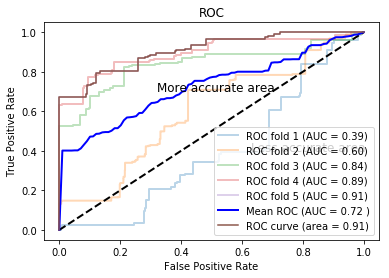

ROC CURVE score - 0.7902411219111749

-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)


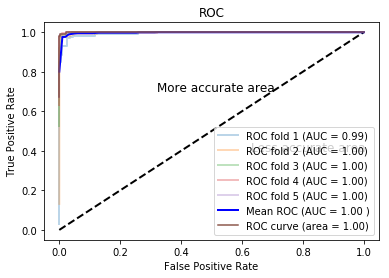

ROC CURVE score - 0.9997274997250853

-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=200, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


C:\Users\juan\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


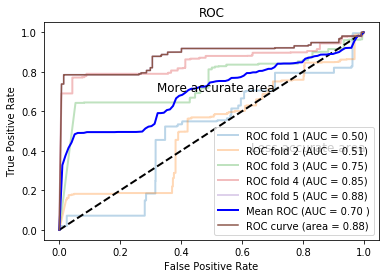

ROC CURVE score - 0.7024554102563458

-----------------------------------------------------------------------------------------------



In [22]:

# numero de splits para cross validation
cv = StratifiedKFold(n_splits=5,shuffle=False)

# svm ficou muito lento

for model in [clf_B,clf_C,clf_D]:
    
    print "\n-----------------------------------------------------------------------------------------------\n" + str(model)
       
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        prediction = model.fit(X.iloc[train],merge_bids.outcome.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        y_scores = model.predict_proba(X_test)[:,1]
        #pickle.dump(model, open(str(model)+'.sav', 'wb'))
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.show()

  
    #############################################################
    print("ROC CURVE score - %s" % roc_auc_score(y_test, y_scores))
            
    print "\n-----------------------------------------------------------------------------------------------\n"

GaussianNB(priors=[0.1, 0.9])_modelo
Confusion matrix, without normalization
[[  6279 790625]
 [   458 123195]]
Normalized confusion matrix
[[0.01 0.99]
 [0.   1.  ]]


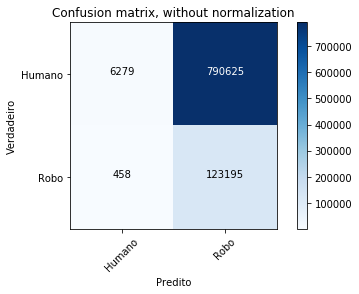

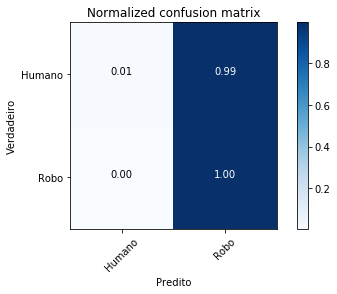

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)_modelo
Confusion matrix, without normalization
[[796884     20]
 [ 13497 110156]]
Normalized confusion matrix
[[1.00e+00 2.51e-05]
 [1.09e-01 8.91e-01]]


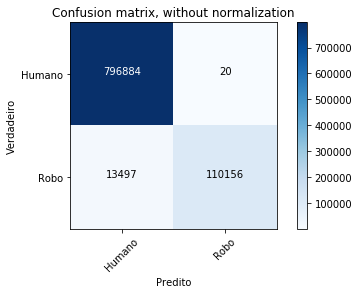

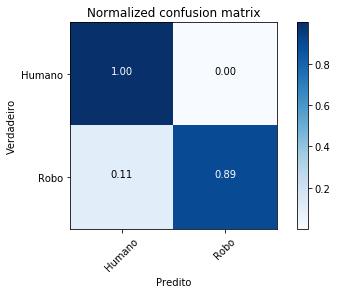

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=200, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)_modelo
Confusion matrix, without normalization
[[787925   8979]
 [ 72299  51354]]
Normalized confusion matrix
[[0.99 0.01]
 [0.58 0.42]]


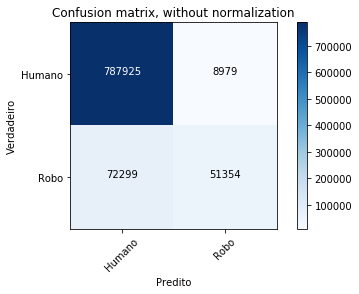

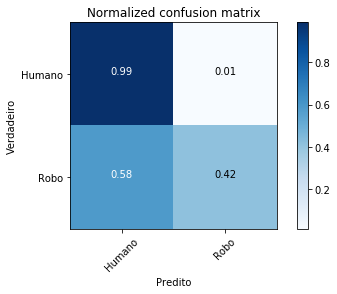

In [44]:
import itertools  
from sklearn.metrics import confusion_matrix

class_names = ['Humano', 'Robo']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

for model in [clf_B,clf_C, clf_D]:

    y_pred = model.predict(X_test)    
    
    print(str(model)+'_modelo')
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


Carregando modelos

In [19]:
pickle.dump(clf_B, open('clf_B.sav', 'wb'))
pickle.dump(clf_C, open('clf_C.sav', 'wb'))
pickle.dump(clf_D, open('clf_D.sav', 'wb'))

In [23]:
clf_B2 = pickle.load(open('clf_B.sav', 'rb'))
clf_C2 = pickle.load(open('clf_C.sav', 'rb'))
clf_D2 = pickle.load(open('clf_D.sav', 'rb'))

Vou exportar os dados obtidos e criar uma predição Básica para ver como os modelos estão dando resultado no Desafio.

In [24]:
z = 1
for model in [clf_B2,clf_C2,clf_D2]:

    print(str(model)+'----------\n')

    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    
    predic = pd.Series(y_pred)
    
    test = pd.read_csv('test.csv')
    test['prediction'] = predic
    test[['bidder_id', 'prediction']].to_csv(str(z)+'_sub.csv', index=False)
    z = z+1
    
 


GaussianNB(priors=[0.1, 0.9])----------

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=66, verbose=0, warm_start=False)----------

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=200, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)----------



In [22]:
pickle.dump(clf_B2, open('clf_B2.sav', 'wb'))
pickle.dump(clf_C2, open('clf_C2.sav', 'wb'))
pickle.dump(clf_D2, open('clf_D2.sav', 'wb'))

Testando as submissões simples <br>
<img src="img/basic-0pred.PNG" />

O melhor modelo por enquanto foi o Gaussian NB, que conseguiu alcançar quase 51% com todos os dados.

Os modelos ainda não estão generalizando bem, por tanto irei testar e criar outros modelos e ajustar alguns parametros.


In [33]:
import pickle
mGNB    = pickle.load(open('clf_B2.sav', 'rb'))
mForest = pickle.load(open('clf_C2.sav', 'rb'))
mSGD    = pickle.load(open('clf_D2.sav', 'rb'))

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

eclf1 = VotingClassifier(estimators=[('lr', mGNB), ('rf', mForest), ('gnb', mSGD)], voting='soft', weights=[1, 1, 2])
eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict_proba(X_test)[:, 1]
y_pred = eclf1.predict(X_test)
predic = pd.Series(predictions)
predic.head()

test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('VotingModel.csv', index=False)
print (roc_auc_score(y_test, predictions))
#print 'F1 score:', f1_score(y_test, y_pred,average='weighted')


C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9755544149282063


Obtive um score bom na métrica ROC de 97%.

Para testar o modelo vou exportar novamente os dados em arquivo e ver o resultado no Kaggle.

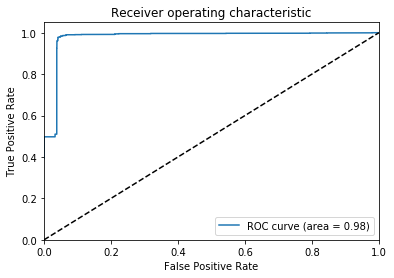

In [24]:
# ROC
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



Resultado KAggle 0.50825

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[770736,  26168],
       [ 62156,  61497]], dtype=int64)

Para melhor entendimento dos erros do modelo, aqui mostrei uma matrix de confusão.

O modelo ainda necessita de ajustes, pois o score do kaggle atingindo foi 0.46863.

Em busca de encontrar relação entre o roc score e o score do kaggle, resolvi utilizar o F1 score e o precision score para ajudar a avaliar os resultados.

In [26]:
#pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


model = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=8)
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
predic = pd.Series(predictions)
predic.head()

test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('xboost.csv', index=False)
print (roc_auc_score(y_test, predictions))
print 'F1 score:', f1_score(y_test, y_pred)
print 'Precision:' ,precision_score(y_test, y_pred)  

0.9999974885013277
F1 score: 0.5820327657842683
Precision: 0.7015000285176525


Testando as submissões simples <br>
<img src="img/xboost.PNG" />

Obtive uma melhora no score utlizando xgboost, depois de ter testato um série de algortimos para classificação, irei começar a otimiza-los com Gridsearch

GridSearch otimização de parametros

In [27]:
lista_c = list(range(1,11))
print(lista_c)
penalidades = ['l1','l2']

parametros_grid = dict(C=lista_c, penalty=penalidades)
print (parametros_grid)

lr = LogisticRegression()

grid = GridSearchCV(lr, parametros_grid, cv=10, scoring='accuracy')

grid.fit(X_train, y_train)

predictions = grid.predict_proba(X_test)[:, 1]

predic = pd.Series(predictions)
predic.head()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


0    0.105653
1    0.235756
2    0.064498
3    0.042558
4    0.092749
dtype: float64

In [28]:
print (roc_auc_score(y_test, predictions))
print 'Precision:' ,precision_score(y_test, y_pred)  

0.7227087904332733
Precision: 0.7015000285176525


In [29]:
print (grid.best_params_)
print(grid.best_score_)


{'penalty': 'l1', 'C': 1}
0.8632753032403678


In [31]:
test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('logistic-tunning.csv', index=False)

In [64]:
lista_d = list(range(1,11))
lista_w = list(range(1,6,2))

parametros_grid = dict(max_depth=lista_d, min_child_weight=lista_w)

model = XGBClassifier(n_estimators=250)

grid = GridSearchCV(model, parametros_grid)
grid.fit(X_train, y_train)
predictions = grid.predict_proba(X_test)[:, 1]

predic = pd.Series(predictions)
predic.head()
test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('xboost-tunado.csv', index=False)
print (roc_auc_score(y_test, predictions))
print 'F1 score:', f1_score(y_test, y_pred)
print 'Precision:' ,precision_score(y_test, y_pred)  

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\juan\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

0.999996763533685
F1 score: 0.5582381268139966
Precision: 0.8511759733479191


In [65]:
print (grid.best_params_)
print(grid.best_score_)

{'max_depth': 10, 'min_child_weight': 5}
0.9999920855358045


Não consegui aumentar o Score desta vez, irei testar novamente os parametros.
E aumentar on_estimators.

<img src="img/xboost.PNG" />


In [69]:
#pip install xgboost

n_estimators = [100, 200, 300]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
parametros_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=lista_d, min_child_weight=lista_w)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

model = XGBClassifier()

grid = GridSearchCV(model, parametros_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid.fit(X_train, y_train)
predictions = grid.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

predic = pd.Series(predictions)
predic.head()
test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('xboost-tunado2.csv', index=False)
print (roc_auc_score(y_test, predictions))
print 'F1 score:', f1_score(y_test, y_pred)
print 'Precision:' ,precision_score(y_test, y_pred) 

0.9992732573140591
F1 score: 0.5582381268139966
Precision: 0.8511759733479191


In [70]:
print (grid.best_params_)
print(grid.best_score_)

{'n_estimators': 300, 'learning_rate': 0.1}
0.9955092399041698


Com a  uma pequena melhora

<img src="img/xboost-tunado2.PNG" />

In [73]:
#pip install xgboost

n_estimators = [350]
learning_rate = [0.1]


parametros_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=lista_d, min_child_weight=lista_w)
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)

model = XGBClassifier()

grid = GridSearchCV(model, parametros_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid.fit(X_train, y_train)
predictions = grid.predict_proba(X_test)[:, 1]

predic = pd.Series(predictions)
predic.head()
test['prediction'] = predic
test[['bidder_id', 'prediction']].to_csv('xboost-tunado3.csv', index=False)
print (roc_auc_score(y_test, predictions))
print 'F1 score:', f1_score(y_test, y_pred)
print 'Precision:' ,precision_score(y_test, y_pred) 



0.9999989670850028
F1 score: 0.5582381268139966
Precision: 0.8511759733479191


In [75]:
print (grid.best_params_)
print(grid.best_score_)

#salvando modelo para testes posteriores
pickle.dump(grid, open('xb3-model.sav', 'wb'))
pickle.dump(predictions, open('xb3.sav', 'wb'))

{'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1}
0.9999944133193914
